# 03 K-Means Implementation Challenge

In this challenge you will write the k-means algorithm from scratch to generate classifications of the vegetation types in the Kowen and Sparrow forest using the image data in image_array. We will break this down into 3 steps:

3.1 Picking Initial Mean Guesses

3.2 Clustering

3.3 Writing a Maximum Likelyhood Classifier

3.4 Extensions of k-means

You will be expected to do this from scratch using only numpy and matplotlib functions. You cannot just go an impot the scikit-learn KMeans function. First we import our libraries and the training image of Kowen and Sparrow forests.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im

#from google.colab import drive
#drive.mount('/content/gdrive')
image = im.open("KowenAndSparrow.jpg")
image_pixel_list = np.array(image.getdata())
(cols,rows) = image.size
image_array = np.reshape(image_pixel_list,(rows,cols,3))
image_array = image_array[400:,400:,:]
image_array = image_array[0:-200,0:-400,:]


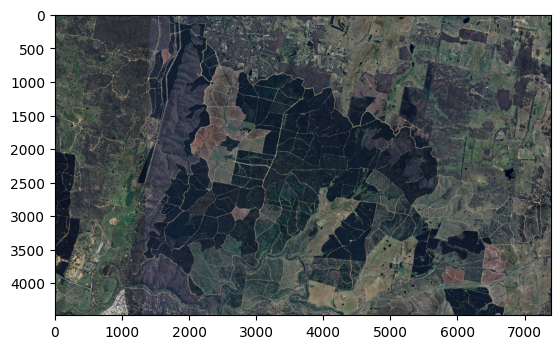

In [34]:
plt.imshow(image_array)

## 3.1 Picking the initial means

You will write a function that chooses the initial means. There is a few options, in order of difficulty:

- Pick K evenly spaced points on the line in $\mathbb{R}^3$ between $(0,0,0)$ and $(255,255,255)$ as mentioned on Pg233 of Richards.

- Computing the brightness distributions for each channel and using that to pick k initial means.

- k-means++ (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf), this is a more advanced method, consider doing one of the above first and coming back to this at the end.

You will complete the below function init_means which takes the argument k and returns a kx3 numpy array of initial means (each of the k rows is a different seed mean). For the latter two options you can include a second argument which is the training image array, you can handle this with multiple dispach if you wish.

In [35]:
def init_means(k):
  # This is a solution for the first option
  return np.linspace(np.array([1,1,1]),np.array([255,255,255]),k)

print(init_means(5), np.shape(init_means(5)))

[[  1.    1.    1. ]
 [ 64.5  64.5  64.5]
 [128.  128.  128. ]
 [191.5 191.5 191.5]
 [255.  255.  255. ]] (5, 3)


The following code plots your initial means for k=5:

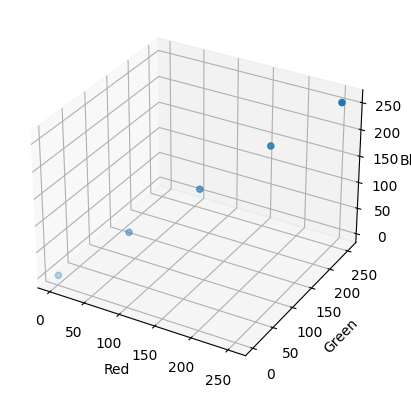

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(init_means(5)[:,0],init_means(5)[:,1],init_means(5)[:,2])
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

## 3.2 Implementing k-means

Write the function k_means which takes as input a number "k" as the number of means, an image array "training_image" and a very small number "epsilon".

- Your function should first use your function init_means to create some initial guess means.

- Your function should then perform the basic k-means interative algorithm untill each mean moves no more than a distance of epsilon over each iteration.

- You may want to make a choice about what norm to use to compute the distances. For example the distance function $d(\vec{v},\vec{u}) = \|\vec{v}-\vec{u}\|_{l_1} $  is quicker to compute but using the $l_2$ norm (corresponding to the euclidean distance) may produce better results.

- Your function should return a $k\times 3$ array of new cluster means. You may choose to round the values to the nearest integer.

In [37]:
def k_means(k, training_image, target_epsilon):

  current_means = init_means(k) # Initialise the means
  (num_rows,num_cols,num_channels) = np.shape(training_image) # Get the dimensions of the image

  epsilon = target_epsilon + 1 # Initialise the tracked epsilon

  while epsilon >= target_epsilon:
    new_means = np.zeros((k,3)) # Initialise the new means
    mean_counters = np.zeros((k,1)) # Initialise the mean counters

    #Classify Each Pixel and accumulate counters
    for row in range(num_rows):
      for col in range(num_cols):

        displacements = current_means - training_image[row,col,:]
        distances = np.linalg.norm(displacements, axis=1)
        min_index = np.argmin(distances)
        new_means[min_index,:] += training_image[row,col,:]
        mean_counters[min_index] += 1

    # compute new means
    new_means = new_means/(mean_counters+0.01)
    epsilon = np.linalg.norm(current_means - new_means)
    print(epsilon)
    current_means = new_means

  return current_means

trained_means = k_means(5, image_array[2000:2002,:,:], 0.05)
print(trained_means)

446.3064310229753
36.42291510334686
20.20383832837233
13.220855409633868
8.976354051090187
6.2580848738159744
4.63543312383115
3.2751053106452663
2.3072195143208267
1.6783577198041968
1.3072297342894328
1.0695456652382442
1.1171212280625025
0.8658236030412827
0.8259586119852735
0.662013204427956
0.6507227025317917
0.6961188254620877
0.5668490395481194
0.680076395677158
0.5328992079671887
0.47262276719764124
0.36717667486267874
0.5609819195552727
0.44383518078025946
0.4862029950099087
0.26999154861949165
0.22576733934493337
0.2160152971620691
0.25407224567778597
0.16816054631852007
0.03618976665446112
[[ 42.35721276  50.16209703  59.05368488]
 [ 70.94744021  79.02945631  78.06874705]
 [ 98.06351838 100.6729099   94.76883211]
 [143.56234031 136.48201709 124.57944774]
 [ 14.36708052  24.97493213  37.73440833]]


## 3.3 Maximum Likelyhood Classification

Each vegetation class in a multispectral image such as an RGB image (named as such because it images across multiple parts of the electromagnetic spectrum) has it's own spectral signature. However, pixels in a given spectral class will vary in their exact values forming a probability distribution which is in our case 3D. Given an unclassifed pixel we evaluate the probability using these distributions that it belongs to each class and classify it as belonging to the class which corresponds to the greatest probability. If we assume eachg distibution is normal with the same mean and standard deviation then MLC reduces to classifying a pixel as belonging to the class with the closest mean.

You will write a ML classifier "k_means_classifer" which takes in an image and a $k\times 3$ array of means. Your function will then go over the image and replace each pixel with the value of the mean that that pixel is closest to. Use plt.imshow to view your segmented image.

In [39]:
def k_means_classifier(image, means):

  #Initialsie returned image
  (num_rows,num_cols,num_channels) = np.shape(image)
  segmented_image = np.zeros((num_rows,num_cols,num_channels))

  # Classify each pixel
  for row in range(num_rows):
    for col in range(num_cols):
      displacements = means - image[row,col,:]
      distances = np.linalg.norm(displacements, axis=1)
      min_index = np.argmin(distances)
      segmented_image[row,col,:] = means[min_index,:]

  return np.floor(segmented_image)

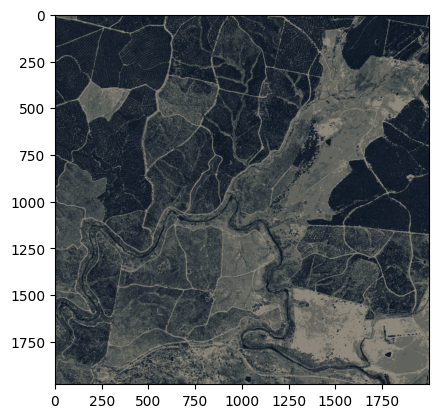

In [41]:
classified_image = k_means_classifier(image_array[2500:4500,2500:4500],trained_means)
plt.imshow(classified_image/255)

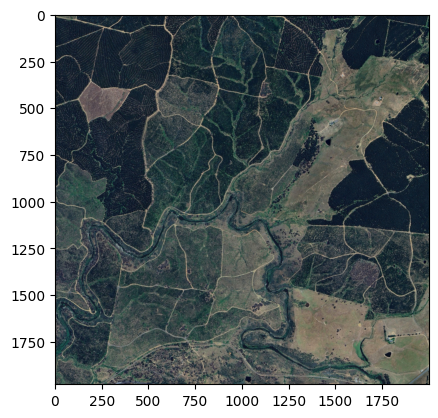

In [42]:
plt.imshow(image_array[2500:4500,2500:4500])

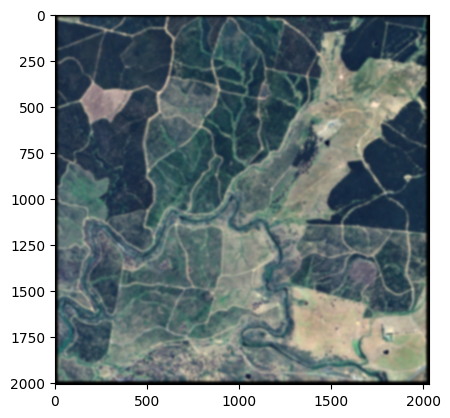

In [56]:
import scipy as sp
oneD_gaussian = sp.signal.windows.gaussian(31,std=6) 
gaussian_kernel = np.outer(oneD_gaussian,oneD_gaussian)

reclass = np.zeros((2007,2030,3))
reclass[:,:,0] = sp.signal.fftconvolve(image_array[2500:4500,2500:4500,0],gaussian_kernel)
reclass[:,:,1] = sp.signal.fftconvolve(image_array[2500:4500,2500:4500,1],gaussian_kernel)
reclass[:,:,2] = sp.signal.fftconvolve(image_array[2500:4500,2500:4500,2],gaussian_kernel)

plt.imshow(reclass/np.max(reclass))

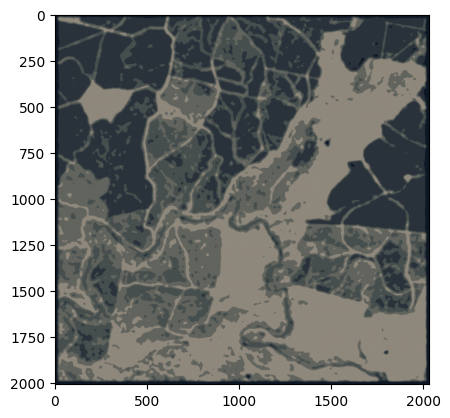

In [57]:
reclass2 = k_means_classifier(255*reclass/np.max(reclass),trained_means)
plt.imshow(reclass2/255)

Below we import an image of the Cotter forest, run your classifier on this image data (cotter_image_array) with the means trained on the Kowen and Sparrow image. What do you notice?

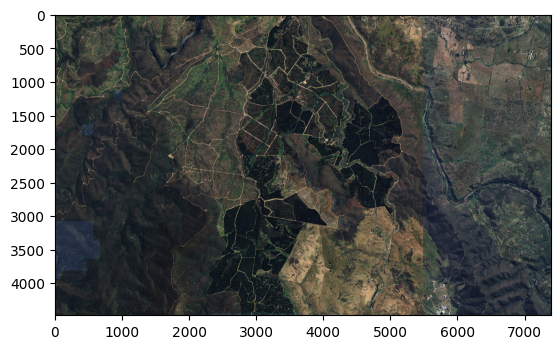

In [ ]:
cotter_image = im.open("Cotter.jpg")
cotter_image_pixel_list = np.array(cotter_image.getdata())
(cols,rows) = cotter_image.size
cotter_image_array = np.reshape(cotter_image_pixel_list,(rows,cols,3))
cotter_image_array = cotter_image_array[400:,400:,:]
cotter_image_array = cotter_image_array[0:-200,0:-400,:]
plt.imshow(cotter_image_array)

In [ ]:
plt.imshow(np.floor(k_means_classifier(cotter_image_array,trained_means))/255)

KeyboardInterrupt: 

## 3.4 Extension of k-means

Write a new function k_means_extended based on your function k_means that implements some of the improvements suggested on Page 233 of Richards.

Perhaps k_means_extended chooses to split clusters and increase the number of means if the standard deviation of a cluster exceeds a certain threshold. Likewise it could choose to delete cluster means if their associated clusters contain a less than a certain threshold number of points. You will need to think about what number of iterations you allow to occur before you start splitting clusters or deleting means. You could also consider merging clusters that are very close together.

You may also choose to update your classifier to utilise the image statistics to make it a true maximum likelyhood classifier.

In [ ]:
def k_means_extended(k, training_image, epsilon):

  means = init_means(k)

  return np.array([])